# Resolución de problema de clasificación

## 1. Carga de datos e importación de librerías

In [92]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import tensorflow as tf

from sklearn import datasets
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier, BaggingClassifier, ExtraTreesClassifier, IsolationForest, RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import SelectKBest
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler, OneHotEncoder, RobustScaler, Normalizer
from sklearn.preprocessing import QuantileTransformer, KBinsDiscretizer, PolynomialFeatures

from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

#TODO Introducir el dataset con el que se vaya a trabajar
df = pd.read_csv('titanic.csv')
df.head()



,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [95]:

#! Algunas características han cambiado desde notebooks a la versión usada para este ejercicio
#! Comprobar que la versión es la misma 

print('Versión sklearn :' , sklearn.__version__) # 1.5.0
print('Versión  tensorflw:' , tf.__version__)   # 2.17.0
print('Versión  pandas:' , pd.__version__)   # 2.2.2
print('Versión  numpy:' , np.__version__)   #1.26.4
print('Versión  seaborn:' , sns.__version__) #0.13.2

Versión sklearn : 1.5.0
Versión  tensorflw: 2.17.0
Versión  pandas: 2.2.2
Versión  numpy: 1.26.4
Versión  seaborn: 0.13.2


## 2. Exploratory data analysis (EDA)

0. Exploracion del dataset (info, describe, shape)
1. Realizar un histplot para tener una noción general.
2. Realizar un gráfico controlando los categóricos, después los exploraremos en mayor porfundida (sns.countplot())
3. Realizar un heatmap para ver correlaciones.
4. Realizar un scatterpolot para explorar las correlaciones vistas.
5. Utiliza boxplot para ver la dispersión de los datos y detectar Outliers.

In [41]:
print('Shape: ', df.shape)
#Obtenemos información sobre el tipo de dato y los nulos por columna
df.info()

Shape:  (891, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


In [42]:

#TODO Separamos los categóricos de los numéricos

categorical_features = ['sex', 'embarked', 'class', 'who', 'deck', 'embark_town', 'alive', 'alone']
numerical_features = ['survived','pclass', 'pclass', 'age', 'sibsp', 'parch', 'fare']

#TODO Definimos la columna de salida
target = 'survived'

### Visualización del dataset 


array([[<Axes: title={'center': 'survived'}>,
        <Axes: title={'center': 'pclass'}>],
       [<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'sibsp'}>],
       [<Axes: title={'center': 'parch'}>,
        <Axes: title={'center': 'fare'}>]], dtype=object)

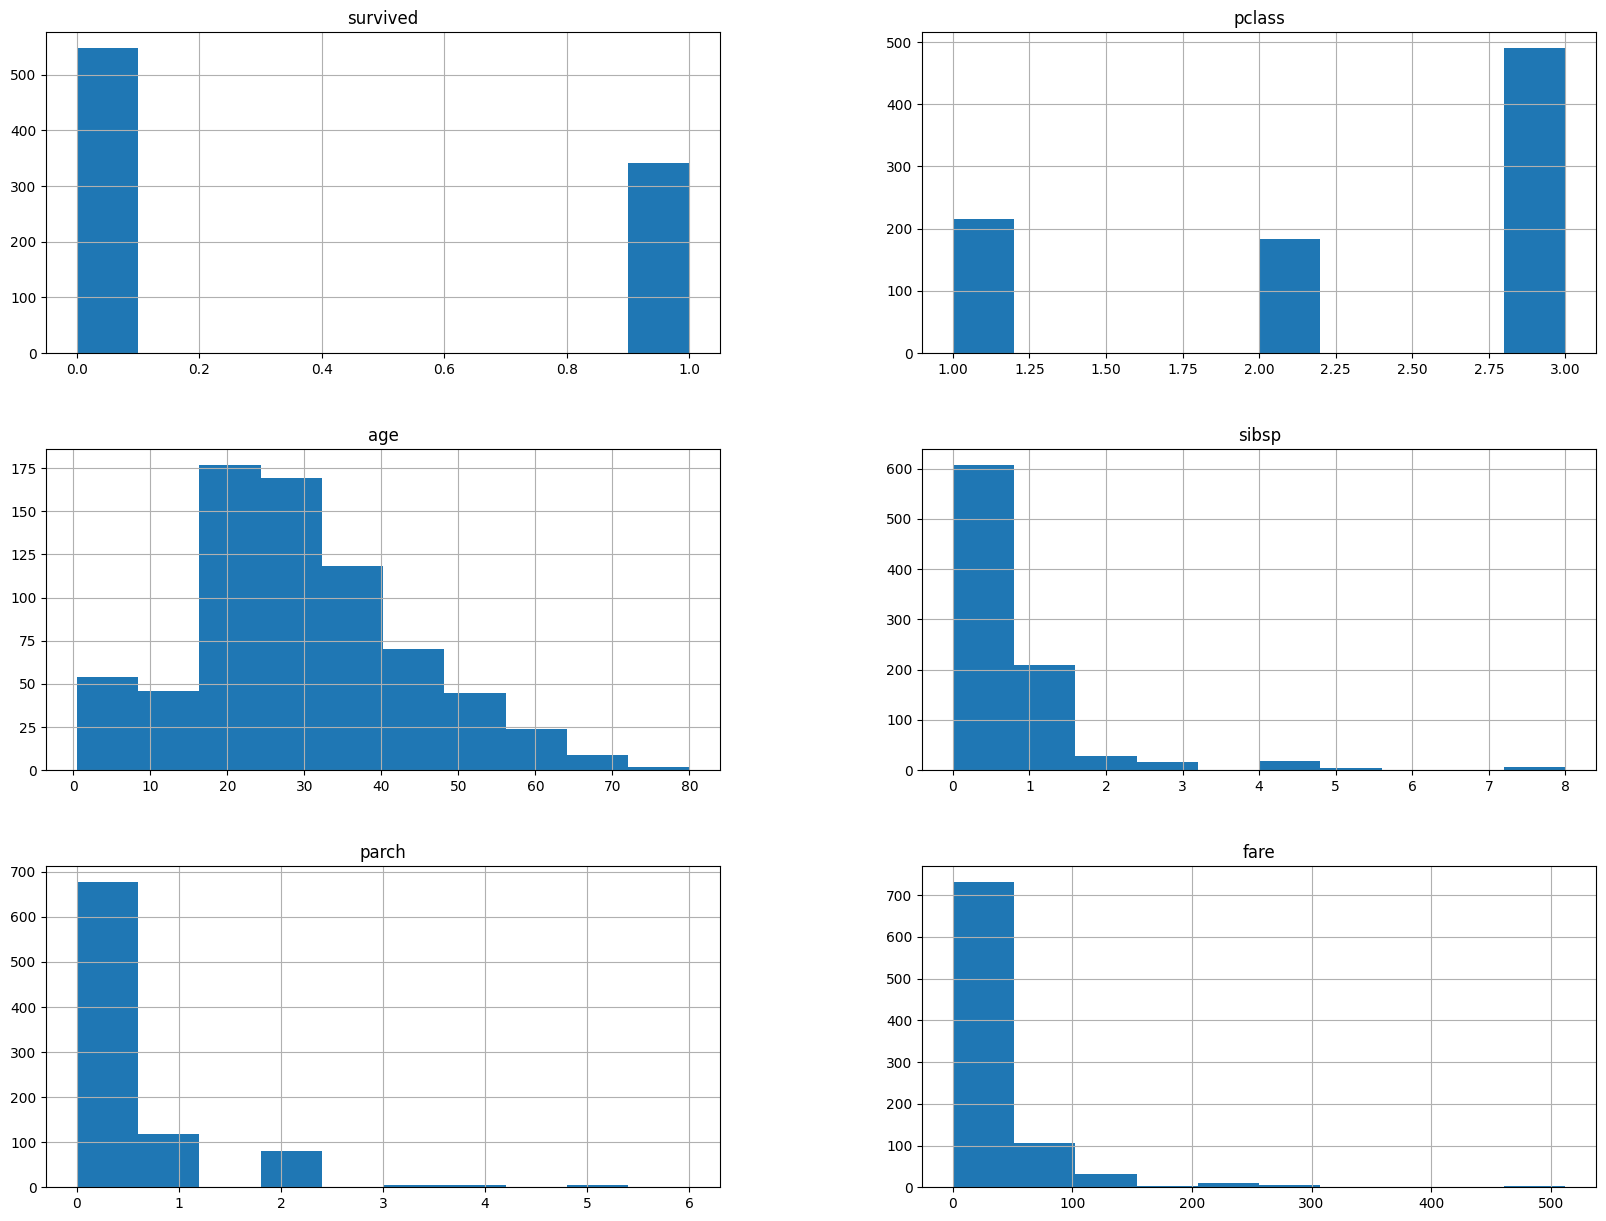

In [43]:
df.hist(figsize=(20, 15))

### Exploración de los categóricos

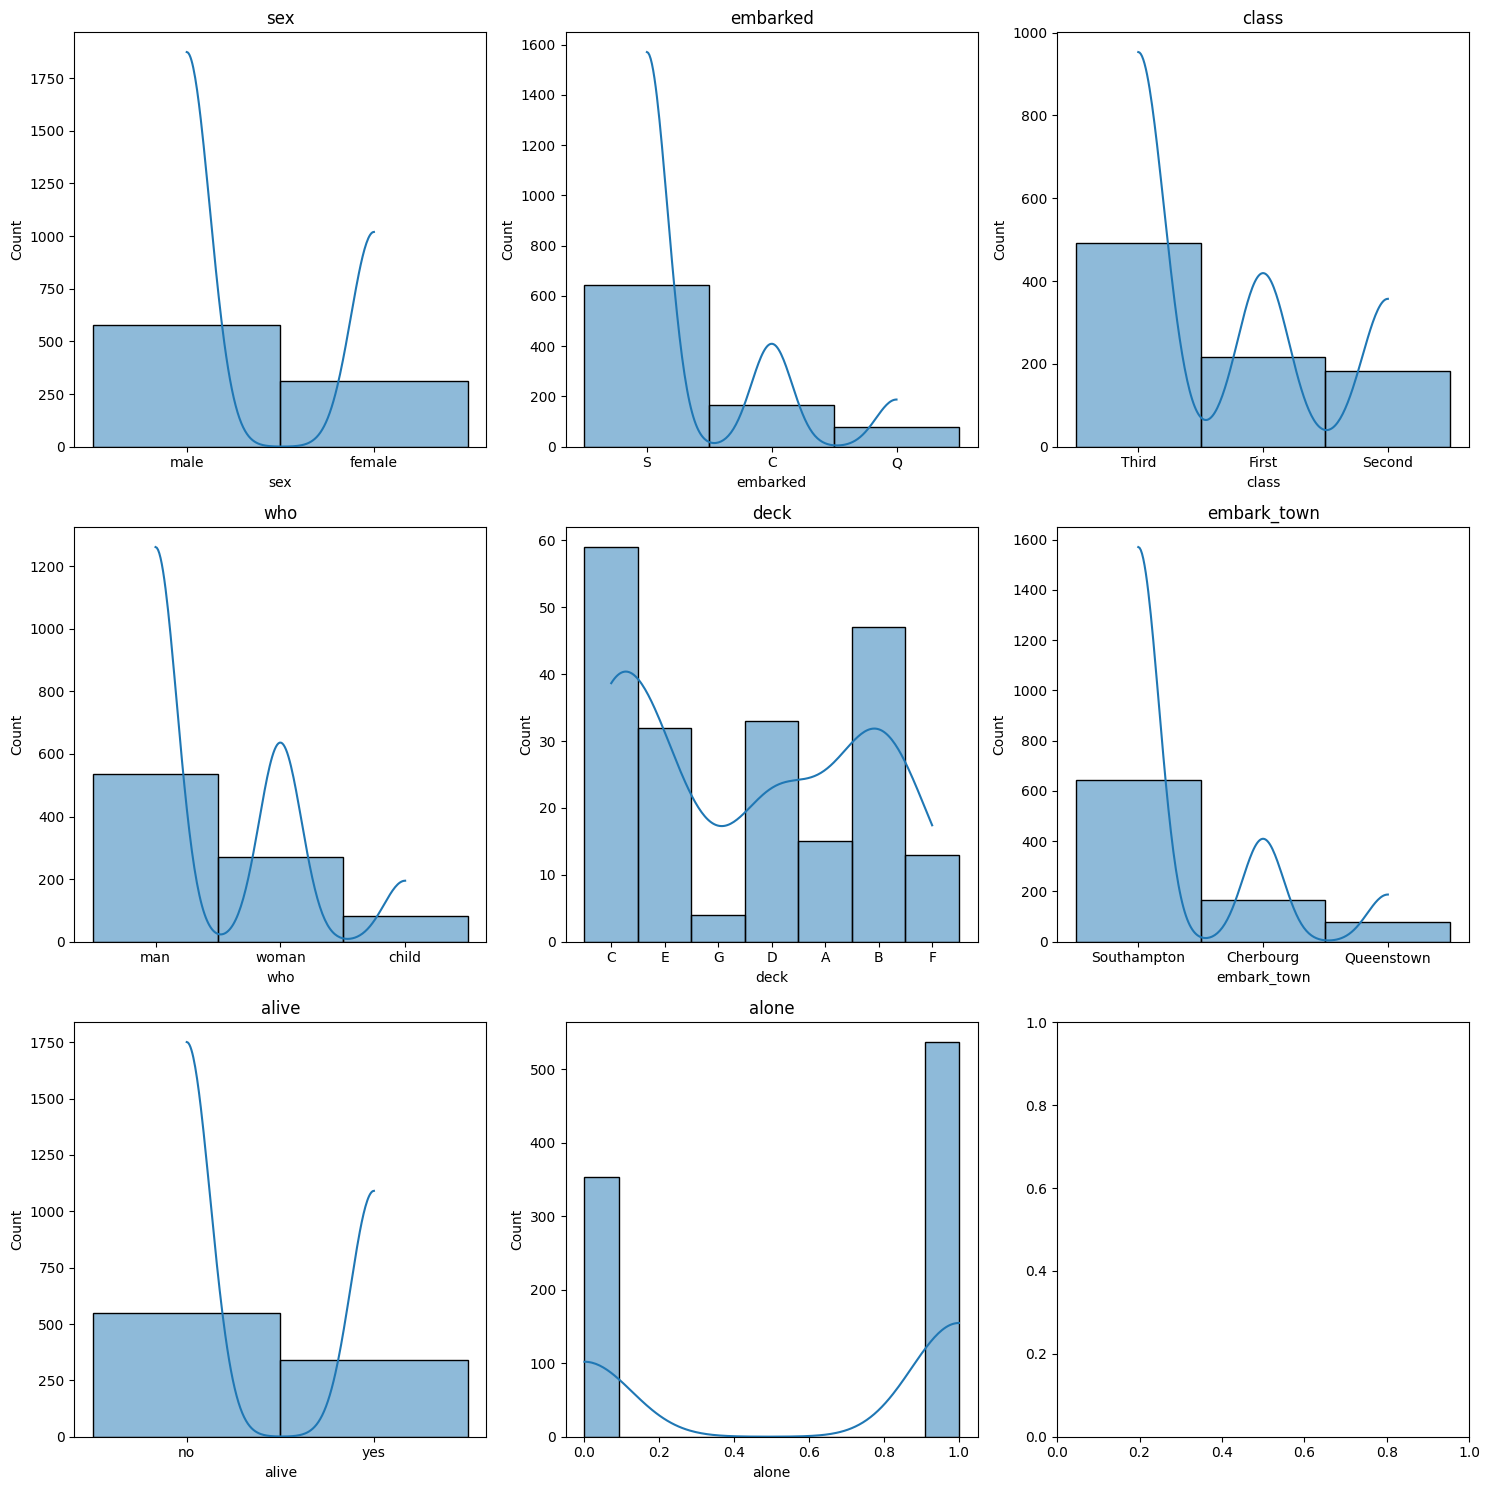

In [44]:

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, feature in enumerate(categorical_features):
    row = i // 3
    col = i % 3
    ax = axs[row, col]
    ax.set_title(feature)
    sns.histplot(df[feature], kde=True, ax=ax)

plt.tight_layout()
plt.show()


### Exploración de correlaciones

<Axes: >

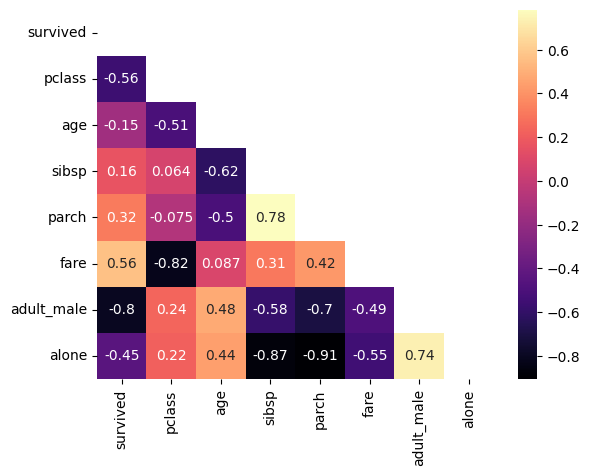

In [45]:
df_corr = df.corr(numeric_only=True)
filter = np.triu(df_corr)
sns.heatmap(df_corr.corr(), annot=True, cmap='magma' , mask=filter)

### Scatterplot para profundizar en las correlaciones

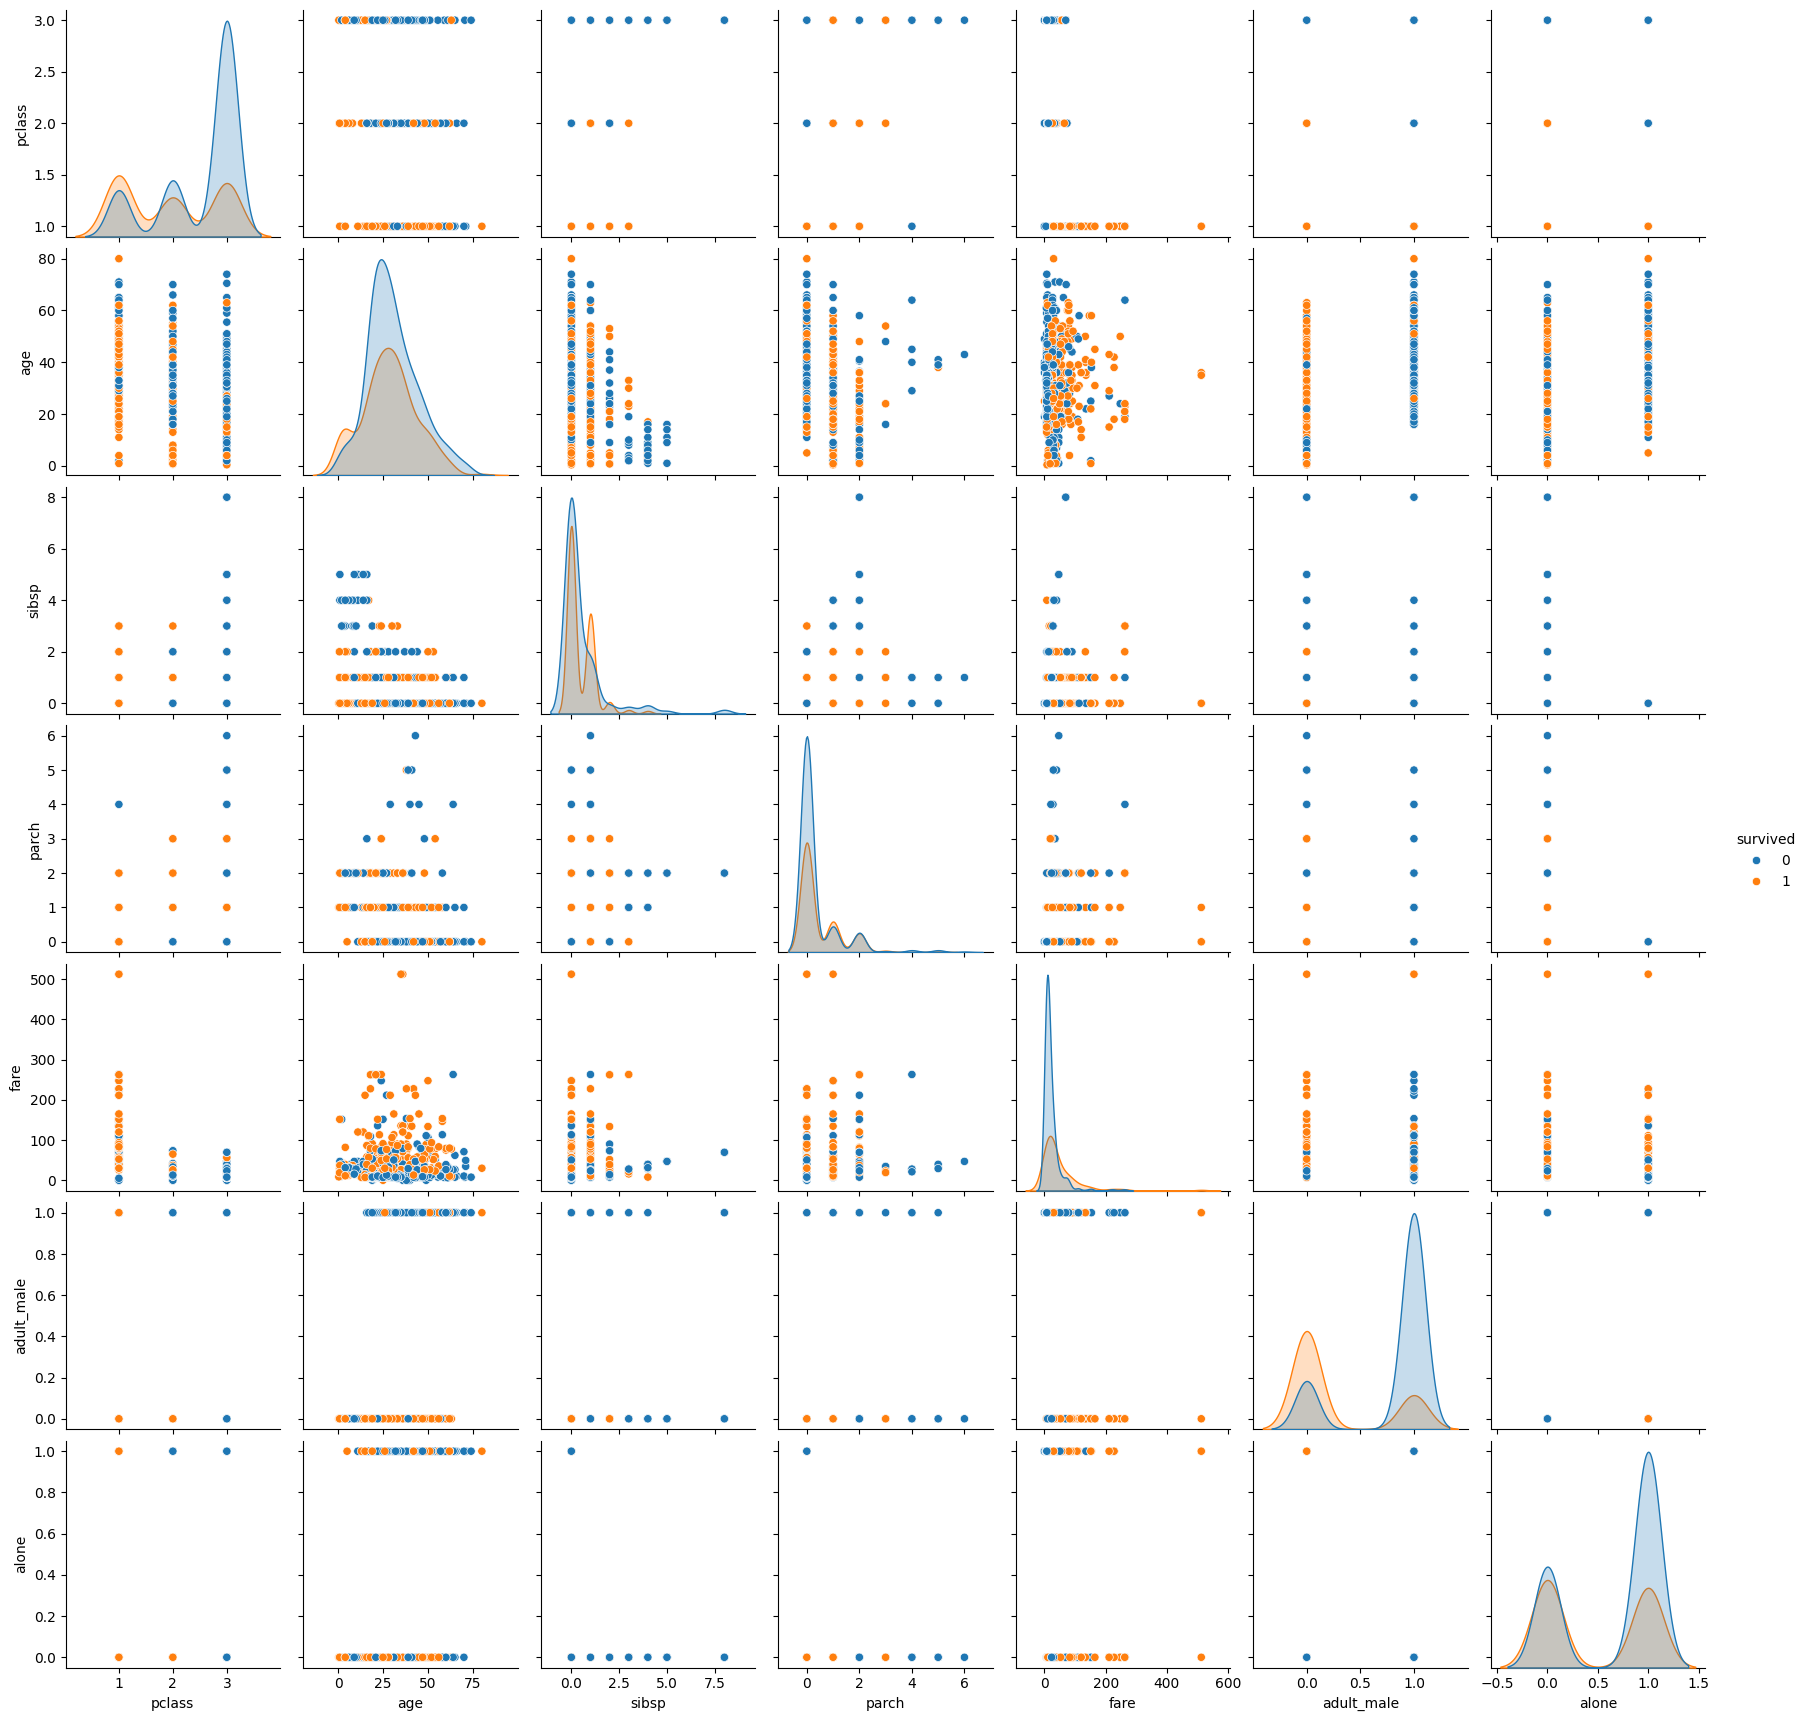

In [46]:
#
# TODO Introducir el nombre de las columnas que se van a utilizar para predecir, añadir una categórica en hue

# SI NECESITAS VER UNA RELACIÓN MUY CONCRETA UTILIZA ESTE OTRO:
#sns.scatterplot(data=df, x='sepal_length', y='sepal_width', hue='species')

#Para ver todas las relaciones posibles
sns.pairplot(df, hue=target)

### Boxplot: distribución de datos y detección de Outliers

Text(0.5, 1.0, 'Boxplot para detectar outliers')

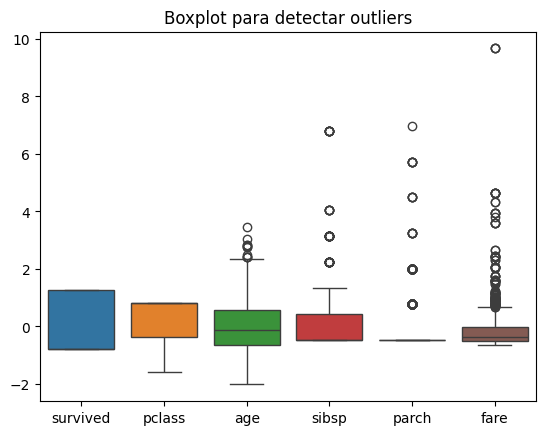

In [48]:
standar_scaler = StandardScaler()
df_scaled = standar_scaler.fit_transform(df[numerical_features])
df_scaled = pd.DataFrame(df_scaled, columns=numerical_features)

#boxplot de una columna con categoría
#sns.boxplot(data=df, x='species', y='sepal_length')

#Boxplot de todas las columnas

sns.boxplot(data=df_scaled)
plt.title('Boxplot para detectar outliers')

## 3. Preparación de las métricas de validación

In [49]:

#TODO Eliminamos temporalmente los NAN y los valores no numéricos.

df_dropnan = df.dropna()

X_dropnan = df_dropnan.drop([target], axis=1)
encoder = OrdinalEncoder()
X_dropnan[categorical_features] = encoder.fit_transform(X_dropnan[categorical_features])
y_dropnan = df_dropnan[target]
y_numerical = LabelEncoder().fit_transform(y_dropnan)


In [50]:
X_dropnan

,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
1,1,0.0,38.0,1,0,71.2833,0.0,0.0,2.0,False,2.0,0.0,1.0,0.0
3,1,0.0,35.0,1,0,53.1000,2.0,0.0,2.0,False,2.0,2.0,1.0,0.0
6,1,1.0,54.0,0,0,51.8625,2.0,0.0,1.0,True,4.0,2.0,0.0,1.0
10,3,0.0,4.0,1,1,16.7000,2.0,2.0,0.0,False,6.0,2.0,1.0,0.0
11,1,0.0,58.0,0,0,26.5500,2.0,0.0,2.0,False,2.0,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
871,1,0.0,47.0,1,1,52.5542,2.0,0.0,2.0,False,3.0,2.0,1.0,0.0
872,1,1.0,33.0,0,0,5.0000,2.0,0.0,1.0,True,1.0,2.0,0.0,1.0
879,1,0.0,56.0,0,1,83.1583,0.0,0.0,2.0,False,2.0,0.0,1.0,0.0
887,1,0.0,19.0,0,0,30.0000,2.0,0.0,2.0,False,1.0,2.0,1.0,1.0


In [51]:

#TODO PARA PROBLEMAS DE CLASIFICACIÓN (FALTA LA MATRIZ DE CONFUSIÓN)

def calc_predictions(X, y):
    """
    Accuracy: ¿cuántos acierta?
    Precision : ¿Está detectando todos los positivos o deja alguno fuera?
    Recall o sensibilidad: ¿de todos los positivos, cuántos son positivos de verdad? (está colando muchos falsos positivos?)
    F1-score: ¿Puedo combinar Precision y Recall en una sola métrica?
    """
    df_results = pd.DataFrame(columns=['model_name', 'accuracy', 'recall', 'f1_score', 'overall_f1_score'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    models = [
        LogisticRegression(max_iter=1000),
        KNeighborsClassifier(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        SVC(kernel='rbf', C=100, gamma=0.1), 
    ]

    for model in models:
        # entrenamiento y predicciones
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # classification metrics
        model_name = model.__class__.__name__
        accuracy = accuracy_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        overall_f1 = f1_score(y_test, y_pred, average='weighted')

        # guardar resultados
        row = [model_name, accuracy, recall, f1, overall_f1]
        df_results.loc[len(df_results)] = row

    return df_results

calc_predictions(X_dropnan, y_numerical)

,model_name,accuracy,recall,f1_score,overall_f1_score
0,LogisticRegression,1.000000,1.000000,1.000000,1.000000
1,KNeighborsClassifier,0.652174,0.585317,0.571096,0.611635
2,DecisionTreeClassifier,1.000000,1.000000,1.000000,1.000000
3,RandomForestClassifier,0.978261,0.972222,0.976942,0.978141
4,SVC,0.565217,0.503968,0.486607,0.530280


## 4. Preprocesado de datos
1. Tratar valores faltantes o nulos.
2. Transformación de categóricos a numéricos (OrdinalEncoder-entrada // LabelEncoder-salida)
3. Tratar Outliers -si procede... muchas veces vamos a necesitarlos.

4. Escalar datos (estandarizar o normalizar)
5. Reducir dimensionalidad del dataset (eliminacion de features SelectKBest)

6. Creación de nuevas features significativas.
7. Discretización de datos -binarizar o kbins.
8. Corregir distribucion de datos y sesgos.

9. Observar si los datos están desbalanceados -demasiadas muestras de uno y pocos de otro.

### Tratar valores faltantes

Comprobamos dónde están los valores faltantes dentro del dataframe. Opcionalmente, podríamos utilizar df.info() si quisiéramos saber cuántos registros tienen valores para cada columna. 

In [52]:
df_copy = df.copy()
df_copy.isnull().sum()


survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

In [53]:
df_imputed = df.copy()
df_imputed.drop(['embark_town', 'deck'], axis=1, inplace=True)

#TODO Elegir el tipo de IMPUTER que se va a utilizar
simple_imputer = SimpleImputer(strategy='most_frequent')
imputer = KNNImputer()
#imputer = IterativeImputer()

#TODO IMPUTACIÓN DE LOS NUMÉRICOS
df_imputed_col = pd.DataFrame(df_imputed[target])
imputer.fit(df_imputed_col)
df_imputed[target] = imputer.transform(df_imputed_col)
df_imputed[target] = df_imputed[target].astype('float64')


df_imputed_col = pd.DataFrame(df_imputed['age'])
imputer.fit(df_imputed_col)
df_imputed['age'] = imputer.transform(df_imputed_col)
df_imputed['age'] = df_imputed['age'].astype('float64')


#TODO IMPUTACIÓN DE LOS CATEGÓRICOS
df_imputed_col= pd.DataFrame(df_imputed['embarked'])
simple_imputer.fit(df_imputed_col)
df_imputed['embarked'] = simple_imputer.transform(df_imputed_col).flatten()
df_imputed['embarked'] = df_imputed['embarked']

# Verificamos que ya no hay nulos
print(df_imputed.isnull().sum())
df_imputed.info()

survived      0
pclass        0
sex           0
age           0
sibsp         0
parch         0
fare          0
embarked      0
class         0
who           0
adult_male    0
alive         0
alone         0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   survived    891 non-null    float64
 1   pclass      891 non-null    int64  
 2   sex         891 non-null    object 
 3   age         891 non-null    float64
 4   sibsp       891 non-null    int64  
 5   parch       891 non-null    int64  
 6   fare        891 non-null    float64
 7   embarked    891 non-null    object 
 8   class       891 non-null    object 
 9   who         891 non-null    object 
 10  adult_male  891 non-null    bool   
 11  alive       891 non-null    object 
 12  alone       891 non-null    bool   
dtypes: bool(2), float64(3), int64(3), object(5)
memory usa

In [54]:
X = df_imputed.drop([target], axis=1)
X

,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,alive,alone
0,3,male,22.000000,1,0,7.2500,S,Third,man,True,no,False
1,1,female,38.000000,1,0,71.2833,C,First,woman,False,yes,False
2,3,female,26.000000,0,0,7.9250,S,Third,woman,False,yes,True
3,1,female,35.000000,1,0,53.1000,S,First,woman,False,yes,False
4,3,male,35.000000,0,0,8.0500,S,Third,man,True,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,male,27.000000,0,0,13.0000,S,Second,man,True,no,True
887,1,female,19.000000,0,0,30.0000,S,First,woman,False,yes,True
888,3,female,29.699118,1,2,23.4500,S,Third,woman,False,no,False
889,1,male,26.000000,0,0,30.0000,C,First,man,True,yes,True


In [55]:
#
#TODO Si te has cargado alguna columna, escribela en esta lista
cols_to_remove = ['embark_town', 'deck']

categorical_features = [cat for cat in categorical_features if cat not in cols_to_remove]

#COMPROBACIÓN DE MÉTRICAS DE EVALUACIÓN
X = df_imputed.drop([target], axis=1)
X[categorical_features] = OrdinalEncoder().fit_transform(df_imputed[categorical_features])
y = LabelEncoder().fit_transform(df_imputed[target])

calc_predictions(X,y)

,model_name,accuracy,recall,f1_score,overall_f1_score
0,LogisticRegression,1.000000,1.000000,1.000000,1.000000
1,KNeighborsClassifier,0.757848,0.734362,0.739621,0.753523
2,DecisionTreeClassifier,1.000000,1.000000,1.000000,1.000000
3,RandomForestClassifier,1.000000,1.000000,1.000000,1.000000
4,SVC,0.847534,0.844835,0.842199,0.848054


### Convertir categóricos a numéricos

Puesto que algunos métodos para tratar Outliers son sensibles a los categóricos, vamos a proceder a convertirlos en numéricos ahora. Disponemos de los siguientes métodos:

-get_dummies : método genérico de pandas. Sobredimensiona el df con demasiadas columnas. No recomendable.

-LabelEncoder : clase de ScikitLearn para datos de salida.

-OrdinalEncoder: clase de scikitLearn para datos de entrada.

-OneHotEncoder : crear columnas con 0 y 1 para indicar si la categoría es o no. Puede sobredimensionar el dataset... así que de momento no vamos a utilizarlo mucho.

In [56]:
#Utilizaremos el ordinal encoder para transformar la columna categórica a numérica en la X

ordinal_encoder = OrdinalEncoder()

df_2 = df_imputed.copy()
df_2[categorical_features] = ordinal_encoder.fit_transform(df_2[categorical_features])

X = df_2.drop(target, axis=1) 
y = df_2[target] 

calc_predictions(X,y)

,model_name,accuracy,recall,f1_score,overall_f1_score
0,LogisticRegression,1.000000,1.000000,1.000000,1.000000
1,KNeighborsClassifier,0.757848,0.734362,0.739621,0.753523
2,DecisionTreeClassifier,1.000000,1.000000,1.000000,1.000000
3,RandomForestClassifier,1.000000,1.000000,1.000000,1.000000
4,SVC,0.847534,0.844835,0.842199,0.848054


### Identificar outliers y tratarlos (si procede)
CONSIDERACIONES:
1. El IQR es para datos univariantes. Si vas a trabajar con varias columnas, usa el Isolation Forest.
2. El isolation Forest no se lleva bien con los categóricos. Asegúrate de quitarlos de este paso.
3. El Isolation Forest no trabaja con NaN ni valores faltantes. Hay que manejarlos antes de ajustar el modelo.

In [57]:
# Configurar Isolation Forest (la contaminación es la proporción de outliers esperados)
iso = IsolationForest(contamination=0.01)  

df_3 = df_2.copy()

# Elimina las columnas no relevantes para la detección de outliers.. por ejemplo los categóricos (aunque ahora sean numéricos)
df_3 = df_3.drop(columns=[target])

# Ajusta el modelo y predecir outliers
outliers = iso.fit_predict(df_3)

# Agregar resultados de outliers como una columna en el DataFrame original
df_2['outlier'] = outliers

# Filtrar outliers
df_3 = df_2[df_2['outlier'] == 1].copy()

# Eliminar la columna 'outlier' del DataFrame df_sin_outliers si no es necesaria
df_3.drop(columns=['outlier'], inplace=True)

# Verificar el tamaño de los DataFrames para asegurarse de que los outliers se eliminaron correctamente
print("Tamaño del df_2:", df_2.shape)
print("Tamaño del df_3 sin outliers:", df_3.shape)


X_3 = df_3.drop([target], axis=1)
y_3 = df_3[target] 

#TODO: EN CASO DE EMPEORAR LAS MÉTRICAS DE EVALUACIÓN, MANTENER LOS OUTLIERS
calc_predictions(X_3,y_3)

Tamaño del df_2: (891, 14)
Tamaño del df_3 sin outliers: (882, 13)


,model_name,accuracy,recall,f1_score,overall_f1_score
0,LogisticRegression,1.000000,1.000000,1.000000,1.000000
1,KNeighborsClassifier,0.778281,0.756229,0.759340,0.776753
2,DecisionTreeClassifier,1.000000,1.000000,1.000000,1.000000
3,RandomForestClassifier,1.000000,1.000000,1.000000,1.000000
4,SVC,0.868778,0.860677,0.859775,0.868939


### Escalar datos 
Utiliza MinMaxScaler si necesitas que todo esté entre 0-1 y no te importan los Outliers.
Utiliza StandarScaler si quieres desviación estándar de 1 y 0 de media, y SÍ te importan los Outliers.

Text(0.5, 1.0, 'Boxplot para detectar outliers')

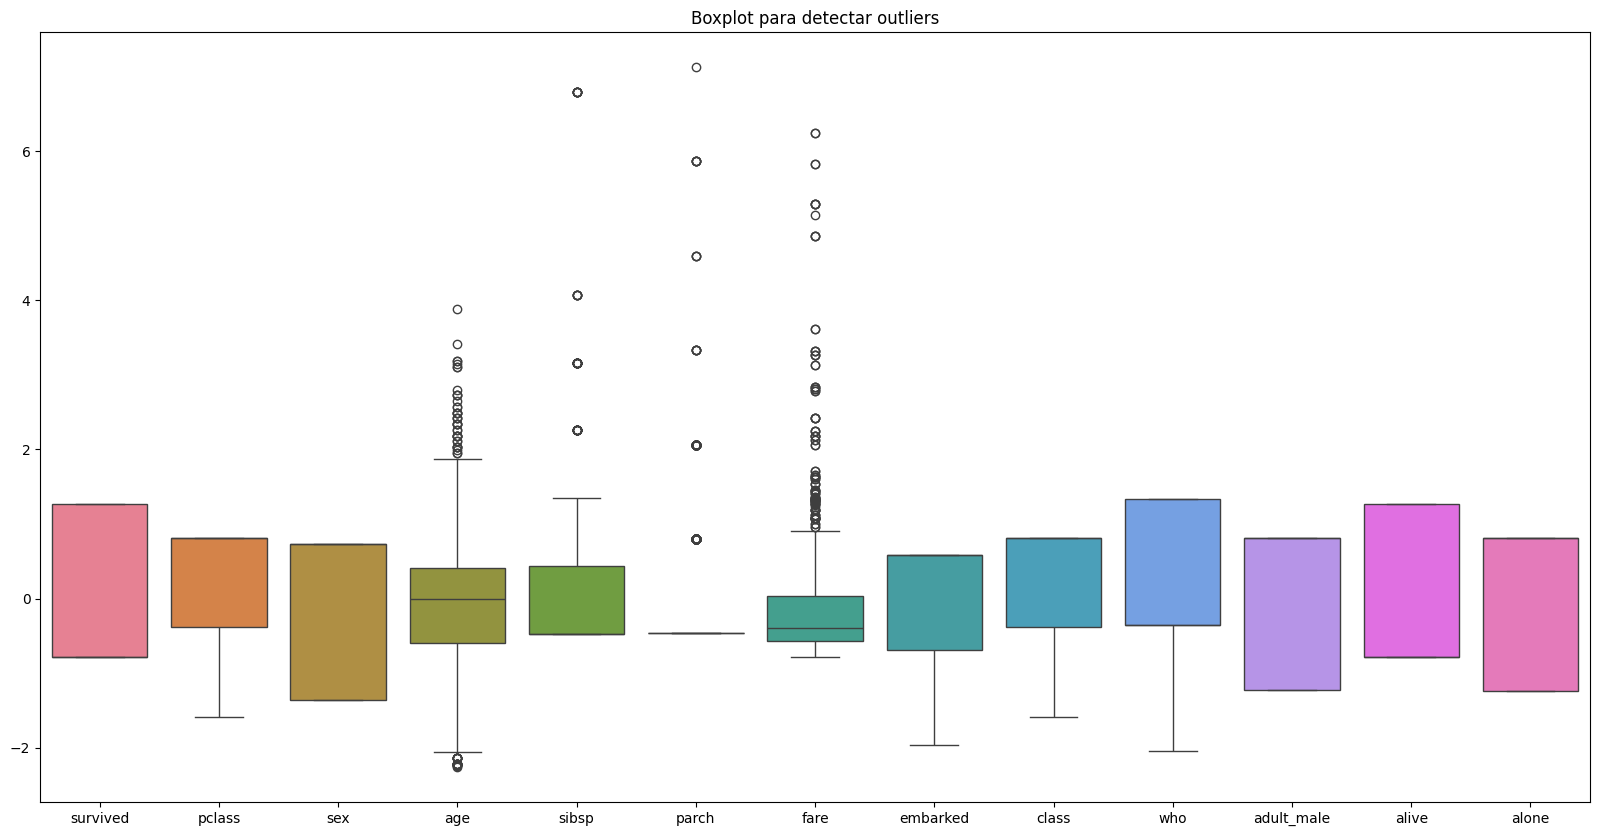

In [61]:
#Escalamos los datos primero para ver qué sucedió con los Outliers quitados
df_3_scaled = pd.DataFrame(standar_scaler.fit_transform(df_3), columns=df_3.columns)

plt.figure(figsize=(20, 10))
sns.boxplot(data=df_3_scaled)
plt.title('Boxplot para detectar outliers')

In [62]:
#! PARA EVITAR CONFLICTO, seguiremos haciendo las pruebas con la X y la y original, DONDE SE MANTIENEN LOS OUTLIERS

#TODO Elige de qué manera quieres escalar los datos
scaler = StandardScaler()
#scaler = MinMaxScaler()

#Escalamos todo menos los categóricos
X_estandar = scaler.fit_transform(df_2.drop(target, axis=1))

#Añadimos la columna categórica
X_estandar = pd.concat([df_2, df_2[target]], axis=1)

#Comprobamos que se ha escalado correctamente
print(X_estandar.head())

calc_predictions(X_estandar, y)



   survived  pclass  sex   age  sibsp  parch     fare  embarked  class  who  \
0       0.0       3  1.0  22.0      1      0   7.2500       2.0    2.0  1.0   
1       1.0       1  0.0  38.0      1      0  71.2833       0.0    0.0  2.0   
2       1.0       3  0.0  26.0      0      0   7.9250       2.0    2.0  2.0   
3       1.0       1  0.0  35.0      1      0  53.1000       2.0    0.0  2.0   
4       0.0       3  1.0  35.0      0      0   8.0500       2.0    2.0  1.0   

   adult_male  alive  alone  outlier  survived  
0        True    0.0    0.0        1       0.0  
1       False    1.0    0.0        1       1.0  
2       False    1.0    1.0        1       1.0  
3       False    1.0    0.0        1       1.0  
4        True    0.0    1.0        1       0.0  


,model_name,accuracy,recall,f1_score,overall_f1_score
0,LogisticRegression,1.000000,1.000000,1.000000,1.000000
1,KNeighborsClassifier,0.838565,0.822279,0.828109,0.836664
2,DecisionTreeClassifier,1.000000,1.000000,1.000000,1.000000
3,RandomForestClassifier,1.000000,1.000000,1.000000,1.000000
4,SVC,0.878924,0.876614,0.874471,0.879242


### Eliminacion de features poco relevantes

Utilizaremos SelectKBest -sabiendo que podemos utilizar árboles de decisión o RFE. 
Con SelectKBest hay distintos métodos dependiendo de si son datos continuos, categóricos, numéricos... Por defecto el sistema es ANOVA, que se basa en la varianza.

In [63]:
df_2.describe()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,alive,alone,outlier
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,29.699118,0.523008,0.381594,32.204208,1.536476,1.308642,1.210999,0.383838,0.602694,0.979798
std,0.486592,0.836071,0.477990,13.002015,1.102743,0.806057,49.693429,0.791503,0.836071,0.594291,0.486592,0.489615,0.200102
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,7.910400,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
50%,0.000000,3.000000,1.000000,29.699118,0.000000,0.000000,14.454200,2.000000,2.000000,1.000000,0.000000,1.000000,1.000000
75%,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,31.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000


In [64]:
df_selectkbest = df_2.drop([target, 'outlier'], axis=1).columns

# Seleccionar las K mejores características utilizando ANOVA F-value (por defecto)
selector = SelectKBest(k=3)
X_selectkbest = selector.fit_transform(X, y)


# Obtener los nombres de las características seleccionadas
mask = selector.get_support() 
selected_features = df_selectkbest[mask] 
print("Selected features:", selected_features)


calc_predictions(X_selectkbest, y)

c:\Users\Administrador.CRISASUSESTUDIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw


Selected features: Index(['sex', 'adult_male', 'alive'], dtype='object')


,model_name,accuracy,recall,f1_score,overall_f1_score
0,LogisticRegression,1.0,1.0,1.0,1.0
1,KNeighborsClassifier,1.0,1.0,1.0,1.0
2,DecisionTreeClassifier,1.0,1.0,1.0,1.0
3,RandomForestClassifier,1.0,1.0,1.0,1.0
4,SVC,1.0,1.0,1.0,1.0


### Creación de nuevas features - PCA

In [65]:
# Aplicar PCA
pca = PCA(n_components=2)  # Queremos reducir a 2 componentes principales
X_pca = pca.fit_transform(X)

# CREAR UN DATAFRAME CON LOS COMPONENTES PRINCIPALES
df_pca = pd.DataFrame(data=X_pca, columns=['componente_1', 'componente_2'])
df_pca['Target'] = y
 
print(df_pca.head())

calc_predictions(X_pca, y)


   componente_1  componente_2  Target
0    -25.156160     -7.076055     0.0
1     39.311885      7.318953     1.0
2    -24.377003     -3.070943     1.0
3     21.052435      4.792409     1.0
4    -24.028539      5.917067     0.0


,model_name,accuracy,recall,f1_score,overall_f1_score
0,LogisticRegression,0.663677,0.591858,0.565505,0.607182
1,KNeighborsClassifier,0.672646,0.646487,0.648895,0.667322
2,DecisionTreeClassifier,0.695067,0.674577,0.676812,0.692312
3,RandomForestClassifier,0.708520,0.678224,0.682357,0.700753
4,SVC,0.663677,0.639024,0.641040,0.659231


### Distribución de los datos - QuantileTransform

En caso de que queramos que los datos sigan una distribución normal, aplicaremos el QuantileTransform.

               model_name  accuracy    recall  f1_score  overall_f1_score
0      LogisticRegression  1.000000  1.000000  1.000000          1.000000
1    KNeighborsClassifier  0.991031  0.988764  0.990614          0.991014
2  DecisionTreeClassifier  1.000000  1.000000  1.000000          1.000000
3  RandomForestClassifier  1.000000  1.000000  1.000000          1.000000
4                     SVC  0.964126  0.970149  0.963110          0.964345


<Axes: xlabel='age', ylabel='Count'>

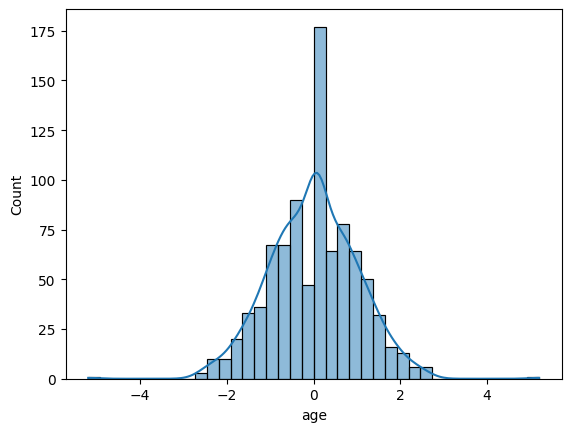

In [68]:

transformer = QuantileTransformer(output_distribution='normal', n_quantiles=100, random_state=0)

# Ajustar y transformar los datos
df_transformed = transformer.fit_transform(df_2)

# Convertir de nuevo a DataFrame para facilitar la visualización
df_transformed = pd.DataFrame(df_transformed, columns=df_2.columns)

X_trans = df_transformed.drop(target, axis=1)
y_trans = df[target]

print(calc_predictions(X_trans,y_trans))
sns.histplot(df_transformed['age'], kde=True)


### Discretización de datos - KbinsDiscretizer

Para realizar este paso será necesario conocer bien nuestro dataset y ver qué datos podemos discretizar, si es que hay algún rango que nos interese crear. 

In [69]:
#
#TODO NO ELIJAS EL TARGET, ELIGE OTRA CARACTERÍSTICA DIFERENTE Y QUE SEA RELEVANTE

column_to_discretize= 'age'
X[column_to_discretize]

0      22.000000
1      38.000000
2      26.000000
3      35.000000
4      35.000000
         ...    
886    27.000000
887    19.000000
888    29.699118
889    26.000000
890    32.000000
Name: age, Length: 891, dtype: float64

               model_name  accuracy    recall  f1_score  overall_f1_score
0      LogisticRegression  1.000000  1.000000  1.000000          1.000000
1    KNeighborsClassifier  0.757848  0.734362  0.739621          0.753523
2  DecisionTreeClassifier  1.000000  1.000000  1.000000          1.000000
3  RandomForestClassifier  1.000000  1.000000  1.000000          1.000000
4                     SVC  0.847534  0.844835  0.842199          0.848054


<Axes: xlabel='age', ylabel='Count'>

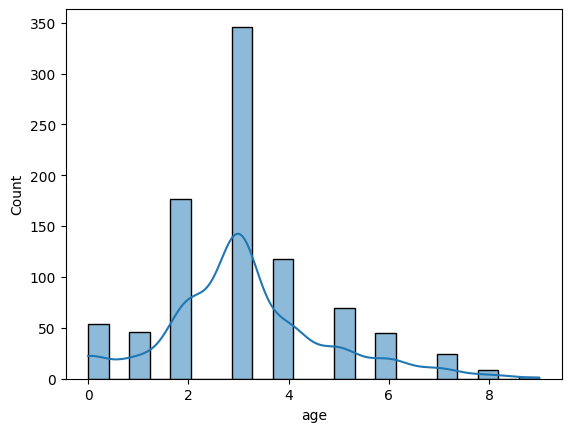

In [70]:
# Crear el discretizador
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')


X_disc = X.copy()

#Modificamos los valores de la columna que queramos discretizar
X_disc[column_to_discretize] = discretizer.fit_transform(X_disc[[column_to_discretize]])

print(calc_predictions(X,y))

#Visualizamos la columna discretizada
sns.histplot(X_disc[column_to_discretize], kde=True)


# Modelado y entrenamiento del modelo

En esta fase procedemos directamente a entrenar el modelo teniendo en cuenta los pasos más convenientes. Para ello, utilizaremos un Pipeline de CLASIFICACIÓN.

In [71]:
df_copy.describe()

,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### 1. Creación de Pipeline de CLASIFICACIÓN

In [73]:
#TODO Adapta esta parte y asegúrate de que la 'y' tiene todos los valores
#y.isnull().sum()
y = df_copy[target]
X = df_copy.drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#! QUITA EL TARGET DE X_TRAIN Y X_TEST, QUE TE VA A DAR ERROR EN EL PIPELINE
categorical_features = [feature for feature in categorical_features if feature != target]
numerical_features
categorical_features

['sex', 'embarked', 'class', 'who', 'alive', 'alone']

In [77]:

# TODO Aplicar IsolationForest e IQR antes de empezar con el pipeline (si es necesario)
# TODO Aplicar LabelEncoder a la columna categórica
# TODO Aplicar discretizer a la columna que se quiera discretizar antes del pipeline


# Crear el pipeline de preprocesamiento para numéricos
pipeline_num = Pipeline([
    ('imputer_iterative', IterativeImputer()),
    ('scaler', StandardScaler()),
    ('select_kbest', SelectKBest(k=3)),
    ('pca', PCA(n_components=2)),
    ('quantile_transformer', QuantileTransformer(output_distribution='normal', n_quantiles=100, random_state=0))
])

# columnas categoricas
pipeline_cat = Pipeline([
    ("imputer_constant", SimpleImputer(strategy='most_frequent')),
     ("encoder", OrdinalEncoder()),
    
])

preprocessor = ColumnTransformer([
    ("numeric", pipeline_num, ['pclass', 'pclass', 'age', 'sibsp', 'parch', 'fare'] ),
    ("categorical", pipeline_cat, ['sex', 'embarked', 'class', 'who', 'alive', 'alone'])
])

preprocessor.fit(X_train, y_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer_iterative',
                                                  IterativeImputer()),
                                                 ('scaler', StandardScaler()),
                                                 ('select_kbest',
                                                  SelectKBest(k=3)),
                                                 ('pca', PCA(n_components=2)),
                                                 ('quantile_transformer',
                                                  QuantileTransformer(n_quantiles=100,
                                                                      output_distribution='normal',
                                                                      random_state=0))]),
                                 ['pclass', 'pclass', 'age', 'sibsp', 'parch',
                                  'fare']),
                                ('categorical',
                                 Pipeline(steps=[('imputer_constant',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OrdinalEncoder())]),
                                 ['sex', 'embarked', 'class', 'who', 'alive',
                                  'alone'])])

### 2. Métricas de evaluación para el Pipeline de Clasificación

In [78]:
def calc_predictions_pipeline(model, X_train, y_train, X_test, y_test):
    df_results = pd.DataFrame(
        columns=['model_name', 'accuracy', 'precision', 'recall_sensitivity', 'recall_specificity', 'f1'])
  
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)


    # classification metrics
    model_name = model.__class__.__name__
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='micro')
    recall_sensitivity = recall_score(y_test, y_pred, average='micro')
    recall_specificity = recall_score(y_test, y_pred, pos_label=0, average='micro')
    f1 = f1_score(y_test, y_pred, average='micro')


    # guardar resultados
    row = [model_name, accuracy, precision, recall_sensitivity, recall_specificity, f1]
    df_results.loc[len(df_results)] = row
    return df_results

### 3. Evaluamos las métricas de nuestro pipeline

In [80]:
# Transformar los datos de entrenamiento y de prueba
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

df_evaluation = pd.DataFrame(columns=['model_name', 'accuracy', 'precision', 'recall_sensitivity', 'recall_specificity', 'f1'])

#TODO ELEGIR LOS MODELOS QUE SE VAYAN A USAR Y CONCATENARLOS AL FINAL DEL TODO

# Modelo 1: KNeighborsClassifier
knn_model = KNeighborsClassifier(weights='distance')
knn_model.fit(X_train_preprocessed, y_train)
knn_eval = calc_predictions_pipeline(knn_model, X_train_preprocessed, y_train, X_test_preprocessed, y_test)
y_knn_pred = knn_model.predict(X_test_preprocessed)

# Modelo 2: RandomForestClassifier
rf_model = RandomForestClassifier(class_weight='balanced')
rf_model.fit(X_train_preprocessed, y_train)
rf_eval = calc_predictions_pipeline(rf_model, X_train_preprocessed, y_train, X_test_preprocessed, y_test)
y_rf_pred = pd.DataFrame(rf_model.predict(X_test_preprocessed))

# Modelo 3: DecissionTree 
dt_model = DecisionTreeClassifier(max_depth=2, class_weight='balanced') #TODO Decidir profunidad del arbol
dt_model.fit(X_train_preprocessed, y_train)
dt_eval = calc_predictions_pipeline(dt_model, X_train_preprocessed, y_train, X_test_preprocessed, y_test)
y_dt_pred = pd.DataFrame(dt_model.predict(X_test_preprocessed))


# Modelo 4: AdaBoost
ada_model = AdaBoostClassifier(estimator=dt_model, n_estimators=50, learning_rate=1.0)
ada_model.fit(X_train_preprocessed, y_train)
ada_eval = calc_predictions_pipeline(ada_model, X_train_preprocessed, y_train, X_test_preprocessed, y_test)
y_ada_pred = pd.DataFrame(ada_model.predict(X_test_preprocessed))


df_evaluation = pd.concat([df_evaluation, knn_eval, rf_eval, dt_eval, ada_eval], axis=0)

df_evaluation

c:\Users\Administrador.CRISASUSESTUDIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1569: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Administrador.CRISASUSESTUDIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1569: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Administrador.CRISASUSESTUDIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1569: UserWarning: Note that pos_label (set to 0) is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\Administrador.CRISASUSESTUDIO\AppData\Lo

,model_name,accuracy,precision,recall_sensitivity,recall_specificity,f1
0,KNeighborsClassifier,0.994413,0.994413,0.994413,0.994413,0.994413
0,RandomForestClassifier,1.000000,1.000000,1.000000,1.000000,1.000000
0,DecisionTreeClassifier,1.000000,1.000000,1.000000,1.000000,1.000000
0,AdaBoostClassifier,1.000000,1.000000,1.000000,1.000000,1.000000


### 4. Dibujamos los residuos de cada modelo

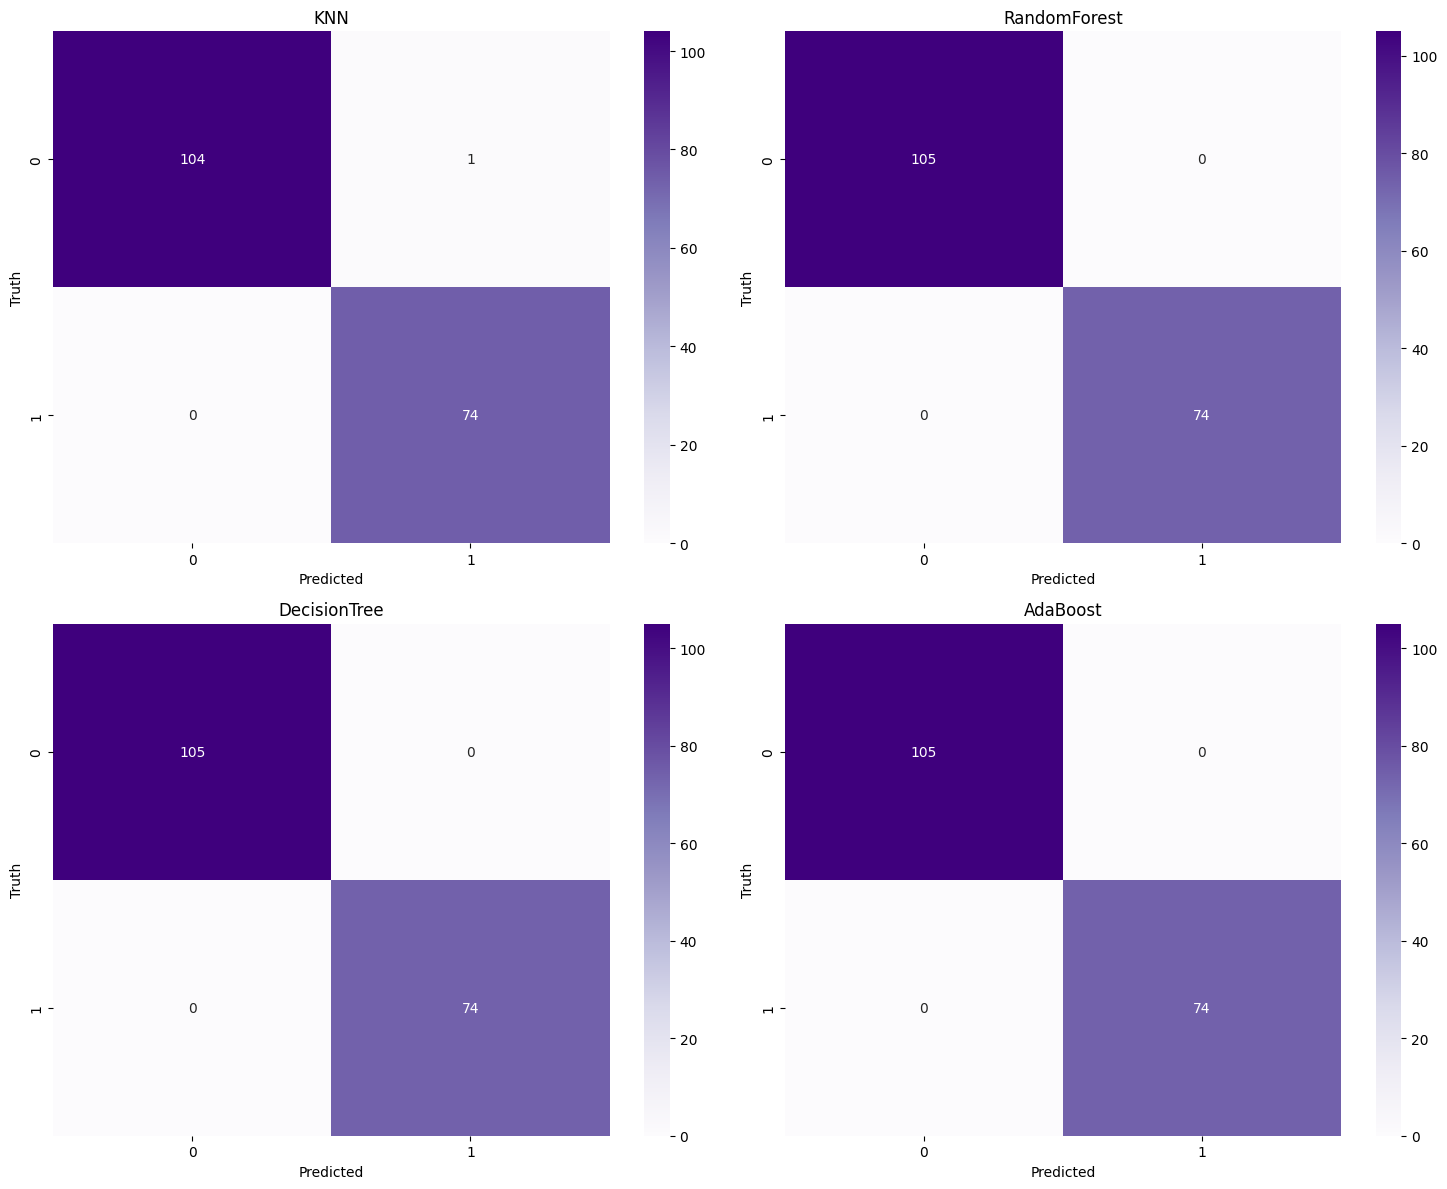

In [81]:
matrix_knn = confusion_matrix(y_test, y_knn_pred)
matrix_rf = confusion_matrix(y_test, y_rf_pred)
matrix_dt = confusion_matrix(y_test, y_dt_pred)
matrix_ada = confusion_matrix(y_test, y_ada_pred)

fig, axs = plt.subplots(2, 2, figsize=(15, 12))  # Adjust the size to fit all plots

# Dibujar la matriz de confusión para KNN
sns.heatmap(matrix_knn, annot=True, fmt='d', ax=axs[0][0], cmap='Purples')
axs[0][0].set_xlabel('Predicted')
axs[0][0].set_ylabel('Truth')
axs[0][0].set_title('KNN')

# Dibujar la matriz de confusión para RandomForest
sns.heatmap(matrix_rf, annot=True, fmt='d', ax=axs[0][1], cmap='Purples')
axs[0][1].set_xlabel('Predicted')
axs[0][1].set_ylabel('Truth')
axs[0][1].set_title('RandomForest')

# Dibujar la matriz de confusión para DecisionTree
sns.heatmap(matrix_dt, annot=True, fmt='d', ax=axs[1][0], cmap='Purples')
axs[1][0].set_xlabel('Predicted')
axs[1][0].set_ylabel('Truth')
axs[1][0].set_title('DecisionTree')

# Dibujar la matriz de confusión para AdaBoost
sns.heatmap(matrix_ada, annot=True, fmt='d', ax=axs[1][1], cmap='Purples')
axs[1][1].set_xlabel('Predicted')
axs[1][1].set_ylabel('Truth')
axs[1][1].set_title('AdaBoost')

plt.tight_layout()
plt.show()


## Keras y clasificación multiclase

Para utilizar una red neuronal, sigue los siguientes pasos:
1. Crea el modelo con Keras usando su arquitectura.
2. Compila el modelo -model.compile.
3. Entreanmiento -model.fit
4. Observa lo que haya salido del modelo: model.sumary()
5. Pintar el error -sns.lineplot()
6. Evaluación del modelo
7. Realiza predicciones.

In [82]:
kr = tf.keras

keras_model_clas = kr.Sequential([
     kr.layers.Dense(10, activation='relu'),
    kr.layers.Dense(5, activation='relu'),
    kr.layers.Dense(5, activation='relu'),
    kr.layers.Dense(5, activation='relu'),
    kr.layers.Dense(2, activation='softmax') #!En la capa de salida preocúpate de que el número de neuronas sea igual al número de clases
])

# Antes de usar Keras, hay que asegurarnos de que los datos tienen cierta forma en la entrada
X_train.shape

keras_model_clas.compile(optimizer=kr.optimizers.Adam(learning_rate=0.01),
              loss=kr.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
              )

keras_model_clas.fit(X_train_preprocessed, y_train, epochs=50, validation_split=0.2)

Epoch 1/100


c:\Users\Administrador.CRISASUSESTUDIO\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6142 - loss: 0.6807 - val_accuracy: 0.6503 - val_loss: 0.5164
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6569 - loss: 0.5569 - val_accuracy: 0.8881 - val_loss: 0.3862
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8308 - loss: 0.4026 - val_accuracy: 0.9371 - val_loss: 0.2566
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8986 - loss: 0.2334 - val_accuracy: 0.9930 - val_loss: 0.0429
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9972 - loss: 0.0393 - val_accuracy: 1.0000 - val_loss: 0.0047
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0095 - val_accuracy: 1.0000 - val_loss: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 3.0553e-04
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.9581e-04 - val_accuracy: 1.0000 - val_

## Evaluación

In [71]:
%pip install graphviz, pydot

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: 'graphviz,'

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [83]:
kr.utils.plot_model(keras_model_clas, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [84]:
keras_model_clas.history.history

{'accuracy': [0.61687171459198,
  0.7135325074195862,
  0.8523725867271423,
  0.9314587116241455,
  0.9982425570487976,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'loss': [0.6462014317512512,
  0.5175405144691467,
  0.3596522808074951,
  0.17490774393081665,
  0.029869280755519867,
  0.0072643207386136055,
  0.001105813542380929,
  0.0004091256996616721,
  0.000208944780752

<Axes: >

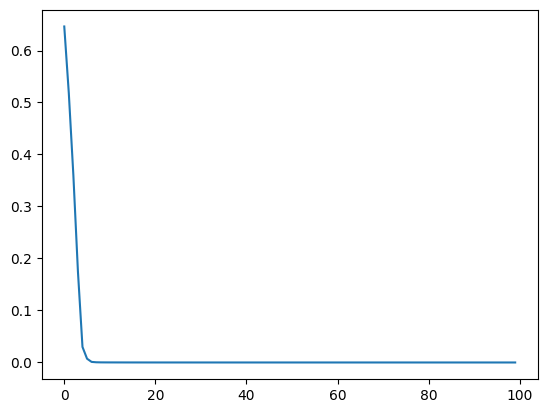

In [85]:
mse = keras_model_clas.history.history['loss']
sns.lineplot(x=range(len(mse)), y=mse)

In [86]:
training_score = keras_model_clas.evaluate(X_train_preprocessed, y_train)
test_score = keras_model_clas.evaluate(X_test_preprocessed, y_test)

print(keras_model_clas.metrics_names)
print('training_score', training_score)
print('test_score', test_score)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 1.3048e-06 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.0156e-06 
['loss', 'compile_metrics']
training_score [1.4815610711593763e-06, 1.0]
test_score [2.0891304757242324e-06, 1.0]


In [87]:
y_pred = keras_model_clas.predict(X_test_preprocessed)
y_pred = np.argmax(y_pred, axis=-1) #La predicción genera distintos pesos que suman 1, con esto se queda simplificado a un array
y_pred

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


array([1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 1], dtype=int64)

In [88]:

df_results = pd.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred.ravel()
})
df_results.head()

,y_test,y_pred
709,1,1
439,0,0
840,0,0
720,1,1
39,1,1


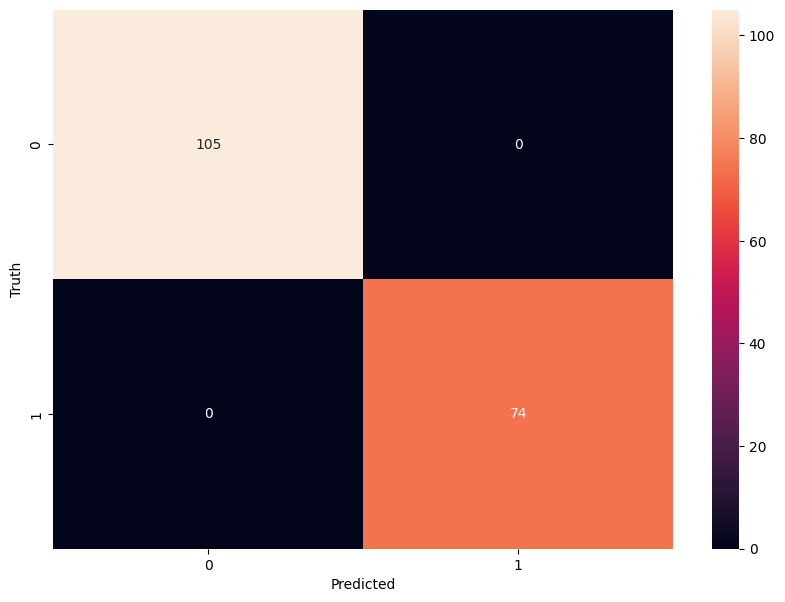

In [89]:

#TODO PINTAMOS UNA MATRIZ DE CONFUSIÓN

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Dibujar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [90]:
df_results['error'] = df_results['y_test'] - df_results['y_pred']
df_results.head(20)

,y_test,y_pred,error
709,1,1,0
439,0,0,0
840,0,0,0
720,1,1,0
39,1,1,0
290,1,1,0
300,1,1,0
333,0,0,0
208,1,1,0
136,1,1,0
